# Primer tipo de preprocesamiento para los dataset del problema Jigsaw/ First type of preprocessing for the Jigsaw problem dataset

Objetivo del problema: Crear un modelo de clasificación binaria que prediga que si un comentario de Reddit infringe alguna norma específica de la comunidad (subreddit). En el archivo Train se representa como 1 si infringió una norma y 0 si no.

In english:
Problem Objective: Create a binary classification model that predicts whether a Reddit comment violates a specific community (subreddit) rule. In the Train file, this is represented as 1 if it violated a rule and 0 if it did not.

## Librerías a utilizar / Libraries to use

In [1]:
!pip install langdetect
!pip install wordcloud
!pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=674e91c813087bf55f502b9f2ecbc2a2b8715bebc37983b2cf6c63f5ffa680eb
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk import SnowballStemmer


## Análisis Exploratorio de Datos / Exploratory Data Analysis

In [3]:
df_train = pd.read_csv('train.csv')
df_train.head()

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1


In [4]:
df_train.shape

(2029, 9)

In [5]:
df_test = pd.read_csv('test.csv')
df_test.head()

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2
0,2029,NEW RAP GROUP 17. CHECK US OUT https://soundcl...,"No Advertising: Spam, referral links, unsolici...",hiphopheads,"Hey, guys, just wanted to drop in and invite y...",Cum Swallowing Hottie Katrina Kaif Cartoon Xvi...,SD Stream Eng - [Chelsea TV USA](http://soccer...,HD Streams: |[ENG HD Stoke vs Manchester Unite...
1,2030,Make your life comfortable. Get up to 15% Disc...,No legal advice: Do not offer or request legal...,AskReddit,Get a lawyer and get the security camera foota...,That isn't drastic. You tried reaching out to ...,So what are you going to do with the insurance...,It's just for Austria & Germany. If you still ...
2,2031,Kickin' ass and selling underwear!\nJust made ...,"No Advertising: Spam, referral links, unsolici...",gonewild,Good story my friend. Check out my blog at ht...,If you know what exactly you need then you don...,CENTIPEDES\n\nSOME BASED PATRIOTS HAVE CREATED...,[So great! Thanks for sharing.](http://www.che...
3,2032,watch hooters best therein http://clickan...,"No Advertising: Spam, referral links, unsolici...",personalfinance,"Earn 50,000 bonus points with Chase Sapphire P...","Cool, front page! I made this print along with...",[Full HD Movie Online Free](http://www.flickma...,* Karambit Black Pearl\n* 0.02137822 Float (un...
4,2033,bitches for free at this point show all h...,"No Advertising: Spam, referral links, unsolici...",Showerthoughts,code free tyrande --->>> [Imgur](http://i.imgu...,My trade link\nhttps://steamcommunity.com/trad...,**HD** [ mio Stadium 102 HD](http://www.genti....,Infographics is an incredible method for showi...


In [6]:
df_test.shape

(10, 8)

Referencias:

* row_id: Número de filas

* body: El texto del comentario publicado en Reddit. Este es el insumo principal que el modelo debe analizar.

* rule: La regla de la comunidad (subreddit) que está en juego. Por ejemplo: “No Advertising”, “No legal advice”.

* subreddit: El subreddit donde apareció el comentario (ejemplo: “soccerstreams”, “sex”).

* positive_example_1 y positive_example_2: Ejemplos de comentarios que sí violan la regla listada en rule.

* negative_example_1 y negative_example_2: Ejemplos de comentarios que no violan la regla listada en rule.

* rule_violation: La etiqueta binaria (target):

    1. 1: El comentario viola la regla.

    2. 0: El comentario no viola la regla.










In english:

References:

* row_id: Number of rows

* body: The text of the comment posted on Reddit. This is the main input the model must analyze.

* rule: The rule of the community (subreddit) in question. For example: “No Advertising”, “No legal advice”.

* subreddit: The subreddit where the comment appeared (example: “soccerstreams”, “sex”).

* positive_example_1 and positive_example_2: Examples of comments that do violate the rule listed in rule.

* negative_example_1 and negative_example_2: Examples of comments that do not violate the rule listed in rule.

* rule_violation: The binary label (target):

1. 1: The comment violates the rule.

2. 0: The comment does not violate the rule.

## Preprocesamiento / Preprocessing

Unificamos las columnas / We unify the columns

In [7]:
df_train["text"] = df_train["subreddit"] + " " + df_train["rule"] + " " + df_train["body"] + " " + df_train["positive_example_1"] + " " + df_train["positive_example_2"] + " " + df_train["negative_example_1"] + " " + df_train["negative_example_2"]
df_test["text"] = df_test["subreddit"] + " " + df_test["rule"] + " " + df_test["body"] + " " + df_test["positive_example_1"] + " " + df_test["positive_example_2"] + " " + df_test["negative_example_1"] + " " + df_test["negative_example_2"]

Limpio el dataset de registros que NO esten en ingles / I clean the dataset of records that are NOT in English.

In [8]:
def detectar_idioma(text):
  try:
    return detect(text)
  except:
    return "unknown"

df_lang = df_train["text"].apply(detectar_idioma)
df_train = df_train[df_lang == "en"]

df_lang_test = df_test["text"].apply(detectar_idioma)
df_test = df_test[df_lang_test == "en"]

In [9]:
df_train.shape

(2023, 10)

In [10]:
df_test.shape

(10, 9)

In [11]:
df_train.head()

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation,text
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0,"Futurology No Advertising: Spam, referral link..."
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0,"soccerstreams No Advertising: Spam, referral l..."
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1,pcmasterrace No legal advice: Do not offer or ...
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1,"sex No Advertising: Spam, referral links, unso..."
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1,"hearthstone No Advertising: Spam, referral lin..."


In [12]:
df_test.head()

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,text
0,2029,NEW RAP GROUP 17. CHECK US OUT https://soundcl...,"No Advertising: Spam, referral links, unsolici...",hiphopheads,"Hey, guys, just wanted to drop in and invite y...",Cum Swallowing Hottie Katrina Kaif Cartoon Xvi...,SD Stream Eng - [Chelsea TV USA](http://soccer...,HD Streams: |[ENG HD Stoke vs Manchester Unite...,"hiphopheads No Advertising: Spam, referral lin..."
1,2030,Make your life comfortable. Get up to 15% Disc...,No legal advice: Do not offer or request legal...,AskReddit,Get a lawyer and get the security camera foota...,That isn't drastic. You tried reaching out to ...,So what are you going to do with the insurance...,It's just for Austria & Germany. If you still ...,AskReddit No legal advice: Do not offer or req...
2,2031,Kickin' ass and selling underwear!\nJust made ...,"No Advertising: Spam, referral links, unsolici...",gonewild,Good story my friend. Check out my blog at ht...,If you know what exactly you need then you don...,CENTIPEDES\n\nSOME BASED PATRIOTS HAVE CREATED...,[So great! Thanks for sharing.](http://www.che...,"gonewild No Advertising: Spam, referral links,..."
3,2032,watch hooters best therein http://clickan...,"No Advertising: Spam, referral links, unsolici...",personalfinance,"Earn 50,000 bonus points with Chase Sapphire P...","Cool, front page! I made this print along with...",[Full HD Movie Online Free](http://www.flickma...,* Karambit Black Pearl\n* 0.02137822 Float (un...,"personalfinance No Advertising: Spam, referral..."
4,2033,bitches for free at this point show all h...,"No Advertising: Spam, referral links, unsolici...",Showerthoughts,code free tyrande --->>> [Imgur](http://i.imgu...,My trade link\nhttps://steamcommunity.com/trad...,**HD** [ mio Stadium 102 HD](http://www.genti....,Infographics is an incredible method for showi...,"Showerthoughts No Advertising: Spam, referral ..."


Filtro los body por stopwords y lematizo las palabras / I filter the body by stopwords and lemmatize the words

In [13]:
nltk.download('stopwords')
stopwords_en = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\b\w+\b', lambda match: stemmer.stem(match.group()), text)  # Stemming
    text = ' '.join([word for word in text.split() if word not in stopwords_en])  # Eliminar stopwords
    return text

df_train['text'] = df_train['text'].apply(preprocess_text)

In [15]:
df_test['text'] = df_test['text'].apply(preprocess_text)

### Worldcloud

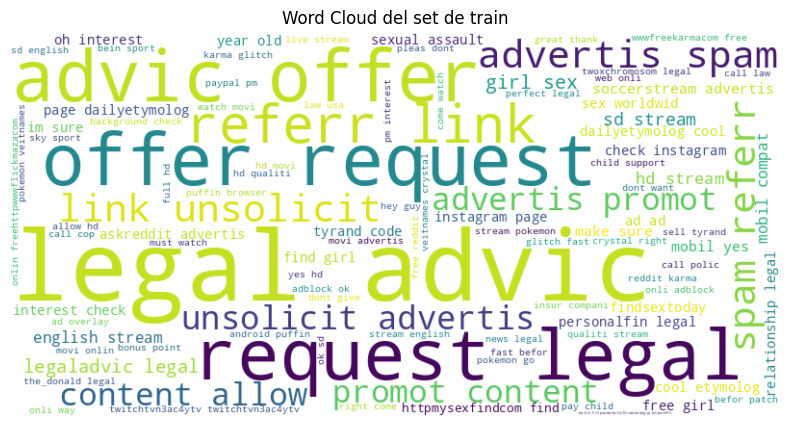

In [16]:
from wordcloud import WordCloud

# Unir todas las palabras en un solo texto
text_data = ' '.join(df_train['text'])

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

# Mostrar el wordcloud utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.title('Word Cloud del set de train')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

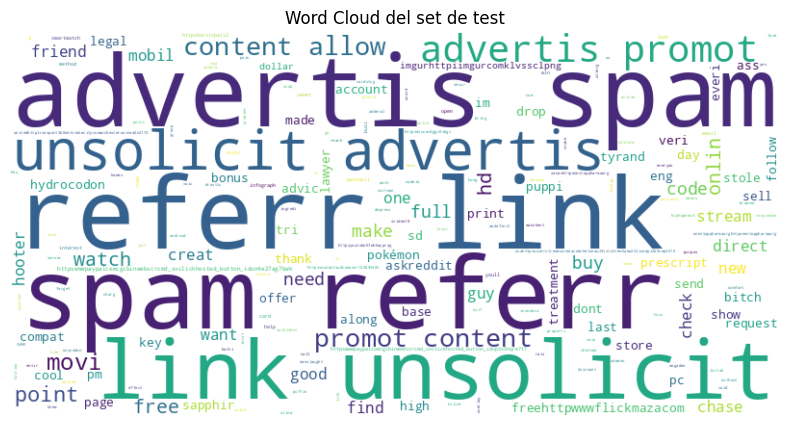

In [17]:
text_data = ' '.join(df_test['text'])

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

# Mostrar el wordcloud utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.title('Word Cloud del set de test')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Guardamos los datasets ya preprocesados / We save the datasets already preprocessed

In [18]:
df_train[["text", "rule_violation"]].to_csv("clean_train.csv", index=False)
df_test[["text"]].to_csv("clean_test.csv", index=False)